# Preprocessing

In [ ]:
!pip install tensorflow-gpu

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
!git clone https://github.com/tensorflow/models.git

In [ ]:
cd models/research

In [11]:
!protoc object_detection/protos/*.proto --python_out=.

In [ ]:
!git clone https://github.com/cocodataset/cocoapi.git

In [ ]:
cd cocoapi/PythonAPI

In [ ]:
!make

In [23]:
cp -r pycocotools ../../models/research

In [ ]:
cd ../../models/research

In [25]:
cp object_detection/packages/tf2/setup.py .

In [ ]:
!python -m pip install .

In [ ]:
pwd

In [ ]:
# From within TensorFlow/models/research/
!python object_detection/builders/model_builder_tf2_test.py

In [ ]:
cd ../../training_demo/pre-trained-models 

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20210210/centernet_mobilenetv2fpn_512x512_coco17_od.tar.gz

In [ ]:
!tar -xvf centernet_mobilenetv2fpn_512x512_coco17_od.tar.gz

In [39]:
#Add trainset location
train_loc = ""
#Add testset location
test_loc = ""

In [40]:
from shutil import copyfile
import os

train_dest = "training_demo/images/train/"
test_dest = "training_demo/images/test/"

train_imgs = [i for i in os.listdir(train_loc)]
train_xmls = [j.replace("jpg","xml") for j in os.listdir(train_loc)]

test_imgs = [i for i in os.listdir(test_loc)]
test_xmls = [j.replace("jpg","xml") for j in os.listdir(test_loc)]

In [41]:
#Add trainset xml locations
train_xml_src = ""
#Add testset xml locations
test_xml_src = ""

In [42]:
for i in train_imgs:
  copyfile(train_loc+i, train_dest+i)

for j in test_imgs:
  copyfile(test_loc+j, test_dest+j)

In [43]:
for i in train_xmls:
  if i!="train.json":
    copyfile(train_xml_src+i, train_dest+i)

In [44]:
for j in test_xmls:
  if j!="val.json":
    try:
      copyfile(test_xml_src+j, test_dest+j)
    except:
      copyfile(train_xml_src+j, test_dest+j)

In [ ]:
%cd training_demo/

# Running the model

In [ ]:
# Create train data:
!python generate_tfrecord.py -x training_demo/images/train -l training_demo/annotations/label_map.pbtxt -o /training_demo/annotations/train.record

# Create test data:
!python generate_tfrecord.py -x training_demo/images/test -l training_demo/annotations/label_map.pbtxt -o /training_demo/annotations/test.record

In [ ]:
cd ../../research/object_detection/

In [ ]:
!python model_main_tf2.py --num_workers=2 --model_dir=training_demo/exported-models/latest_model --pipeline_config_path=training_demo/exported-models/latest_model/pipeline.config

In [ ]:
!python exporter_main_v2.py --input_type image_tensor --pipeline_config_path training_demo/exported-models/latest_model/pipeline.config --trained_checkpoint_dir training_demo/exported-models/latest_model --output_directory training_demo/exported-models/final

In [ ]:
!python model_main_tf2.py --model_dir=training_demo/exported-models/final --pipeline_config_path=training_demo/exported-models/final/pipeline.config --checkpoint_dir=training_demo/exported-models/final/checkpoint

In [234]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2' 
import pathlib
import tensorflow as tf
import cv2 
import argparse
from google.colab.patches import cv2_imshow
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings ('ignore')
from PIL import Image
from torchvision import transforms

In [ ]:
#PROVIDE PATH TO MODEL DIRECTORY
PATH_TO_MODEL_DIR= 'training_demo/exported-models/final'

# PROVIDE PATH TO LABEL MAP
PATH_TO_LABELS = 'training_demo/annotations/label_map.pbtxt'

# PROVIDE THE MINIMUM CONFIDENCE THRESHOLD
MIN_CONF_THRESH = float(0.60)

# LOAD THE MODEL
PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)
model.eval()

In [287]:
def load_image_into_numpy_array(path):
  return np.array(Image.open(path))

In [1]:
def test_model(filename):
  classes = {0:'billete',1:'knife',2:'monedero',3:'pistol',4:'smartphone',5:'tarjeta'}
  gpus= tf.config.experimental.list_physical_devices('GPU')
  for gpu in gpus:
    tf.config.experimental.set_memory_growth (gpu, True)

  IMAGE_PATHS = 'training_demo/images/test/'+filename
  start_time = time.time()


  end_time = time.time()
  elapsed_time = end_time - start_time



  category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,use_display_name=True)

  image = cv2.imread(IMAGE_PATHS)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_expanded = np.expand_dims(image_rgb, axis=0)

  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis, ...]

  detections = detect_fn(input_tensor)

  num_detections = int(detections.pop('num_detections'))
  detections = {key: value [0, :num_detections].numpy()
                for key, value in detections.items()}
  detections['num_detections'] = num_detections

  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

  image_with_detections = image.copy()
  visualization_utils.visualize_boxes_and_labels_on_image_array(
    image_with_detections,
    detections['detection_boxes'],
    detections['detection_classes'],
    detections['detection_scores'],
    category_index,
    use_normalized_coordinates=False,
    max_boxes_to_draw=200,
    min_score_thresh=0.6,
    agnostic_mode=False)

  height, width, _ = image.shape

  [ymin,xmin,ymax,xmax] = detections['detection_boxes'][np.argmax(np.array(detections['detection_scores']))]
  print(ymin,xmin,ymax,xmax)
  [ymin,xmin,ymax,xmax] = [int(height*ymin),int(width*xmin),int(height*ymax),int(height*xmax)]
  print(ymin,xmin,ymax,xmax)

  cropped_image = image[ymin:ymax, xmin:xmax]
  cv2_imshow(cropped_image)

  if not model:
    intialize_model()
  
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  tfms = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize(256),
      transforms.CenterCrop(225),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

  img_tensor = tfms(cropped_image).to('cpu').unsqueeze(0)

  output = model(img_tensor)
  predicted_class = torch.tensor(output,requires_grad=True)
  predicted_class = predicted_class.detach().numpy()
  return classes[np.argmax(predicted_class)]


In [5]:
def initialize_model():
  import torch.nn as nn
  import torch.nn.functional as F
  import torch

  train_acc = []
  test_acc = []
  loss_vals = []

  class Net(nn.Module):
      def __init__(self):
          super(Net, self).__init__()
          self.conv1 = nn.Conv2d(3, 96, 11, stride=2)
          self.pool1 = nn.MaxPool2d(4, stride=2)
          self.conv2 = nn.Conv2d(96, 128, 3, stride=2, padding=2)
          self.pool2 = nn.MaxPool2d(4, stride=2)
          self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
          self.pool3 = nn.MaxPool2d(3, stride=2)
          self.fc1 = nn.Linear(256 * 6 * 6, 2056)
          self.fc2 = nn.Linear(2056,512)
          self.fc3 = nn.Linear(512,256)
          self.fc4 = nn.Linear(256,64)
          self.fc5 = nn.Linear(64,6)

      def forward(self, x):
          x = self.pool1(F.relu(self.conv1(x)))
          x = self.pool2(F.relu(self.conv2(x)))
          x = self.pool3(F.relu(self.conv3(x)))
          x = x.view(-1, 256 * 6 * 6)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = F.relu(self.fc3(x))
          x = F.relu(self.fc4(x))
          x = self.fc5(x)
          return x

  model = Net()
  print(model)
  #Location of .pt file
  file = "../CNNModel/model.pt"
  model.load_state_dict(torch.load(file))

In [6]:
initialize_model()

Net(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(2, 2))
  (pool1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=2056, bias=True)
  (fc2): Linear(in_features=2056, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=6, bias=True)
)


In [264]:
import xml.etree.ElementTree as ET
gt = []

Path_pref = "training_demo/images/test/"
file_list = sorted(os.listdir(Path_pref))

for file in file_list:
  if file[-3:] == 'xml':
    tree = ET.parse(os.path.join(Path_pref,file))
    root = tree.getroot()
    objects = root.findall('object')
    for obj in objects:
      gt.append(obj.find('name').text)

gt = np.array(gt)

In [314]:
def get_test_accuracy(gt):
  preds = []
  Path_pref = "training_demo/images/test/"
  file_list = sorted(os.listdir(Path_pref))
  i = 0

  for file in file_list:
    if file[-3:] == 'jpg':
      print(i)
      i += 1
      preds.append(test_model(file))

  preds = np.array(preds)
  
  return preds

In [ ]:
predictions = get_test_accuracy(gt)

In [280]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.metrics import classification_report

target_classes = ['billete', 'knife', 'monedero', 'pistol', 'smartphone', 'tarjeta']
print(classification_report(gt, predictions, target_names=target_classes))
print()

              precision    recall  f1-score   support

     billete       0.38      0.25      0.30       112
       knife       0.44      0.16      0.24       532
    monedero       0.56      0.16      0.25       124
      pistol       0.38      0.86      0.53       387
  smartphone       0.32      0.24      0.27       130
     tarjeta       0.16      0.17      0.17        63

    accuracy                           0.38      1348
   macro avg       0.37      0.31      0.29      1348
weighted avg       0.41      0.38      0.33      1348




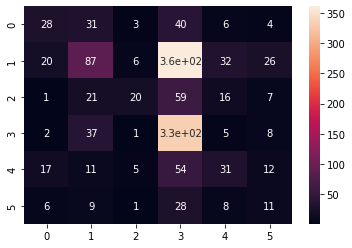

In [286]:
%matplotlib inline
sns.heatmap(confusion_matrix(gt, predictions), annot=True)